# Final project variant 1

Loading the libraries necessary for the project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Task 1

Retention is one of the most important indicators in a company. Your task is to write a function that will count player retention (by days from the player’s registration date).

Loading data

In [2]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stasov/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stasov/shared/problem1-auth_data.csv', sep=';')

Let's study dataframes

In [3]:
reg_data.head(2)

,reg_ts,uid
0,911382223,1
1,932683089,2


In [4]:
auth_data.head(2)

,auth_ts,uid
0,911382223,1
1,932683089,2


In [5]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


There are no empty cells

Remove duplicates if there are any

In [7]:
reg_data = reg_data.drop_duplicates()
auth_data = auth_data.drop_duplicates()

In [8]:
reg_data.shape

(1000000, 2)

In [9]:
auth_data.shape

(9601013, 2)

There were no duplicates

We see that the dates are given as int64 (number of seconds since 1970), let's convert the columns to datetime
Let's get rid of time, since for retention we only need the day of registration and login

In [10]:
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.date
auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.date

We see that everything has changed correctly

In [11]:
reg_data.head(1)

,reg_ts,uid
0,1998-11-18,1


In [12]:
auth_data.head(1)

,auth_ts,uid
0,1998-11-18,1


Let's start writing the function
Explanation: we assume that the names and path to the data will remain unchanged, the files will only be updated

In [13]:
def retention_analysis(start_date, end_date, days):
    """
    
    Function for creating a retention graph

     It accepts the following input data:
     * start_date
     * end_date
     * days - number of days to limit the schedule
        
     As a result, a heat map will be displayed in the selected time intervals
    
    """
    
    #read files
    reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
    auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
    
    #Converting columns to dates
    reg['reg_ts'] = pd.to_datetime(reg.reg_ts, unit='s').dt.date
    auth['auth_ts'] = pd.to_datetime(auth.auth_ts, unit='s').dt.date
    
    #merge files into one
    df = reg.merge(auth, on='uid') 
    df['retention_day'] = (df.auth_ts - df.reg_ts).dt.days
    
    #limit the period according to "days"
    df = df.query('retention_day <= @days')
    df = df[(pd.to_datetime(df['reg_ts']) >= pd.to_datetime(start_date)) & 
            (pd.to_datetime(df['reg_ts']) <= pd.to_datetime(end_date))]
    
    #Grouping before creating a pivot
    group = df \
        .groupby(['reg_ts', 'retention_day'], as_index=False) \
        .agg({'uid': 'count'})
    
    #group into cohorts
    pivot = group.pivot(index='reg_ts', columns='retention_day', values='uid')
    pivot_percent = pivot.copy(deep=True)
    pivot_percent.iloc[:, 1:] = pivot_percent.iloc[:, 1:].div(pivot_percent.iloc[:, 0], axis=0) * 100
       
    #create a heat table
    plt.figure(figsize=(20, 14))
    plt.title('Retention analysis', fontsize=12)
    
    cmap = 'Blues'
    
    ax = sns.heatmap(data=pivot_percent,
                     xticklabels=True,
                     annot=True,
                     cmap=cmap,
                     vmin=0.0,
                     vmax=pivot_percent.iloc[:, 1:].max().max() + 1,
                     fmt='.1f',
                     linewidths=.3,
                     linecolor='white')
    
    ax.set(xlabel='days after registration', ylabel='registration date')
    ax.get_figure()
    
    plt.show()
    
    return

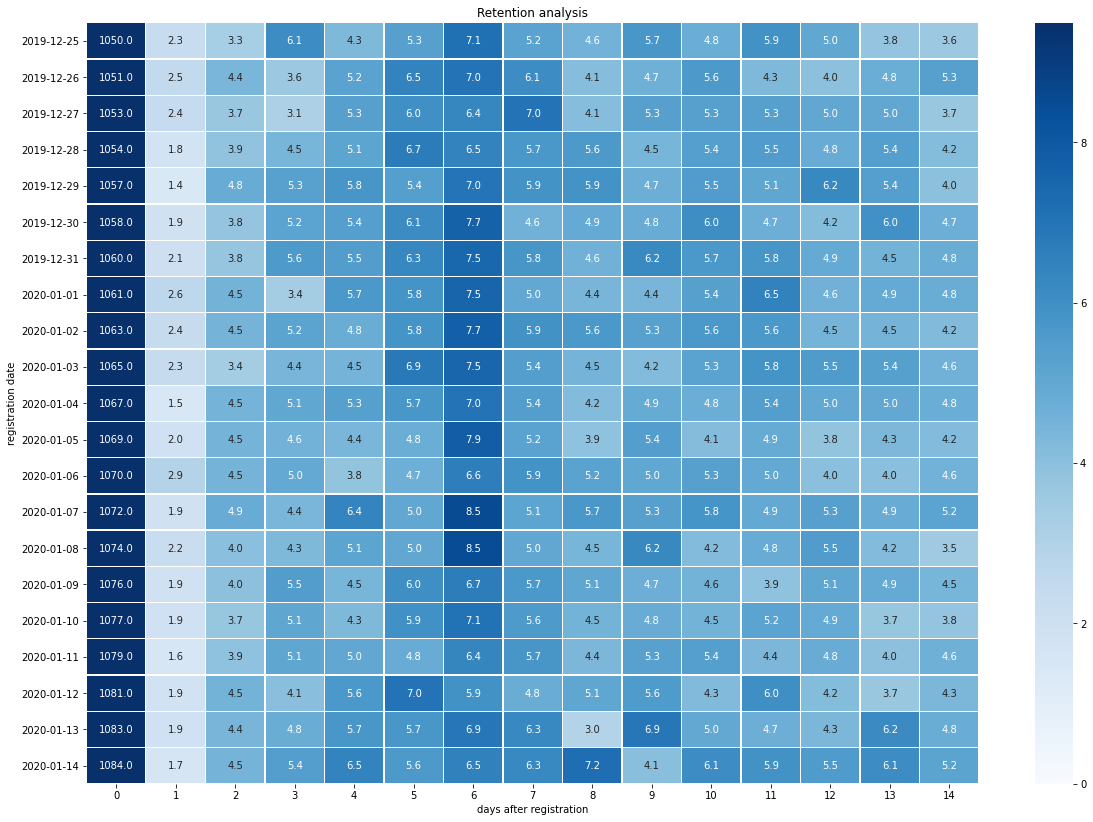

In [14]:
retention_analysis('2019-12-25', '2020-01-14', 14)

# Task 2

There are results of an A/B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. At the same time, in the control group, 1928 players out of 202103 turned out to be paying, and in the test group - 1805 out of 202667.

Which set of proposals can be considered the best? What metrics should be analyzed to make the right decision and how?

Loading data

In [15]:
path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-stasov/data_for_first_project/Проект_1_Задание_2.csv'

In [16]:
results = pd.read_csv(path, sep=';')

In [17]:
results.head(10)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
7,8,0,b
8,9,0,b
9,10,0,a


Checking for duplicates

In [18]:
results.duplicated().sum()

0

Checking whether there are intersecting "user_id" to understand the independence of samples

In [19]:
results.duplicated(subset='user_id').sum()

0

In [20]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [21]:
results.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

While studying the data, we can see the total number of users, the number of people who paid, and the amount of purchases. Let's highlight 3 main metrics:
    
     -CR: conversion to purchase
    
     -ARPU: average bill per user
    
     -ARPPU: average bill of the paying user

Сreate a table of metrics for the control and test groups

In [22]:
control_metrics = {
    'Total Users': len(results[results['testgroup'] == 'a']),
    'Paying Users': len(results[(results['testgroup'] == 'a') & (results['revenue'] > 0)]),
    'Total Revenue': results[(results['testgroup'] == 'a')]['revenue'].sum(),
    'CR': round(len(results[(results['testgroup'] == 'a') & (results['revenue'] > 0)]) / \
          len(results[results['testgroup'] == 'a']) * 100, 2),
    'ARPU': round(results[(results['testgroup'] == 'a')]['revenue'].sum() / \
            len(results[results['testgroup'] == 'a']), 1),
    'ARPPU': round(results[(results['testgroup'] == 'a')]['revenue'].sum() / \
             len(results[(results['testgroup'] == 'a') & (results['revenue'] > 0)]), 1)
}


In [23]:
test_metrics = {
    'Total Users': len(results[results['testgroup'] == 'b']),
    'Paying Users': len(results[(results['testgroup'] == 'b') & (results['revenue'] > 0)]),
    'Total Revenue': results[(results['testgroup'] == 'b')]['revenue'].sum(),
    'CR': round(len(results[(results['testgroup'] == 'b') & (results['revenue'] > 0)]) / \
    len(results[results['testgroup'] == 'b']) * 100, 2),
    'ARPU': round(results[(results['testgroup'] == 'b')]['revenue'].sum() / \
    len(results[results['testgroup'] == 'b']), 1),
    'ARPPU': round(results[(results['testgroup'] == 'b')]['revenue'].sum() / \
    len(results[(results['testgroup'] == 'b') & (results['revenue'] > 0)]), 1)
}

In [24]:
difference_between = {
    'Total Users': test_metrics['Total Users'] - control_metrics['Total Users'],
    'Paying Users': round((test_metrics['Paying Users'] - control_metrics['Paying Users']) / \
    control_metrics['Paying Users'] * 100, 2),
    'Total Revenue': test_metrics['Total Revenue'] - control_metrics['Total Revenue'],
    'CR': round(test_metrics['CR'] - control_metrics['CR'], 2),
    'ARPU': round(test_metrics['ARPU'] - control_metrics['ARPU'], 1),
    'ARPPU': round(test_metrics['ARPPU'] - control_metrics['ARPPU'], 1)
}

In [25]:
summary = pd.DataFrame({
    'Metric': ['Total Users', 'Paying Users', 'Total Revenue', 'CR', 'ARPU', 'ARPPU'],
    'Control': [control_metrics['Total Users'], control_metrics['Paying Users'], control_metrics['Total Revenue'],
                control_metrics['CR'], control_metrics['ARPU'], control_metrics['ARPPU']],
    'Test': [test_metrics['Total Users'], test_metrics['Paying Users'], test_metrics['Total Revenue'],
             test_metrics['CR'], test_metrics['ARPU'], test_metrics['ARPPU']],
    'Difference': [difference_between['Total Users'], difference_between['Paying Users'],
                   difference_between['Total Revenue'], difference_between['CR'],
                   difference_between['ARPU'], difference_between['ARPPU']]
})

In [26]:
summary

,Metric,Control,Test,Difference
0,Total Users,202103.00,202667.00,564.00
1,Paying Users,1928.00,1805.00,-6.38
2,Total Revenue,5136189.00,5421603.00,285414.00
3,CR,0.95,0.89,-0.06
4,ARPU,25.40,26.80,1.40
5,ARPPU,2664.00,3003.70,339.70


As we can see from the table:
    
     -CR in test group below
    
     -ARPU in the test group is higher
    
     -ARPPU in the test group is higher

The difference in average checks of paying users in groups remained unexplored. Let's look at the distribution

In [27]:
results[(results['testgroup'] == 'a') & (results['revenue'] != 0)]['revenue'].describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [28]:
results[(results['testgroup'] == 'b') & (results['revenue'] != 0)]['revenue'].describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Strange values: In the test group, all values are in the range from 2000 to 4000, and in the control group from 200 to 37433, with 75% of them not exceeding 361.

Most likely there are serious outliers in the control group, let's look at them

In [29]:
results.query("testgroup == 'a' and revenue > 4000")

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


We received 123 users with an amount of more than 37,000. If we cut off these users, then the number of paying players will be the same in the compared groups.

However, due to the lack of other conditions, we cannot remove outliers, especially since if we remove them, there will still be a very large difference in cost.

To check CR, add a column with the conversion status

In [30]:
results['was_converted'] = np.where(results['revenue'] == 0, 0, 1)

In [31]:
results.head(2)

,user_id,revenue,testgroup,was_converted
0,1,0,b,0
1,2,0,a,0


Let's separate our groups

In [32]:
control = results.query('testgroup == "a"')
test = results.query('testgroup == "b"')

We know that there are significant group differences in CR. Let's check the statistical significance.

Let's check statistical significance using the Chi-square test. Why this test was chosen:
    
     in this case this is justified, since we want to assess the statistical significance of the differences          between
     two categorical variables: conversion to purchase and membership in the control or test group.
    
And:

     1) All observations are independent
     2) The number of observations in each cell is greater than 5
    
Let's denote the hypotheses:

     -H0: conversion to purchase does not depend on tested promotional offers.
    
     -H1: conversion to purchase depends on the tested promotional offers.

Let's identify the number of paid and non-paid ids in each group

In [33]:
control_cr = control[control['was_converted'] == 1].shape[0]
control_no_cr = control[control['was_converted'] == 0].shape[0]
test_cr = test[test['was_converted'] == 1].shape[0]
test_no_cr = test[test['was_converted'] == 0].shape[0]

Creating a crosstab

In [34]:
cross = pd.DataFrame([[control_cr, control_no_cr],
                      [test_cr, test_no_cr]],
                     index=['Control', 'Test'],
                     columns=['Converted', 'Not Converted'])

In [35]:
cross

,Converted,Not Converted
Control,1928,200175
Test,1805,200862


In [36]:
scipy.stats.chi2_contingency(cross)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[  1863.89924896, 200239.10075104],
        [  1869.10075104, 200797.89924896]]))

A p-value of 0.036 < 0.05 allows us to reject the null hypothesis that there is no significance in the conversion between the control and test groups.

Text(0.5, 1.0, 'Distribution of Revenue - Control vs Test')

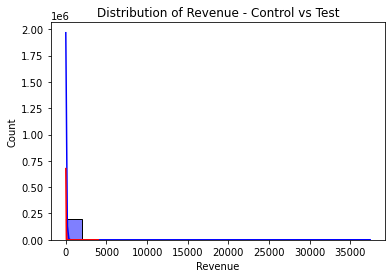

In [37]:
sns.histplot(data=control, x='revenue', color='blue', label='Control', kde=True)
sns.histplot(data=test, x='revenue', color='red', label='Test', kde=True)
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title('Distribution of Revenue - Control vs Test')

The graph shows that neither in the control nor in the test group the distributions are abnormal.

We will also conduct a test for normality of distribution using the Shapiro-Wilk test with the formation of a null hypothesis according to which the data are distributed normally in the population.

In [38]:
shapiro(control.revenue)

ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [39]:
shapiro(test.revenue)

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

The distributions are non-normal. In large samples, as in our case, even taking into account the non-normality of the distribution, the t-test is considered quite reliable in the absence of strong outliers. Strong outliers are present in the control group, so let’s replace t-test with bootstrap:
    
     -Bootstrap allows us to estimate the distribution of sample statistics by repeatedly sampling from the original sample and backtracking. This allows us to obtain the distribution of statistics without assuming a limiting distribution of the original data.

Declare the bootstrap function

In [40]:
def get_bootstrap(
    bootstrap_control,  # numeric values of the first sample
    bootstrap_test,  # numeric values of the second sample
    boot_it=1000,  # number of bootstrap subsamples
    statistic=np.mean,  # statistics we are interested in
    bootstrap_conf_level=0.95  # significance level
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # extracting subsamples
        samples_1 = bootstrap_control.sample(
            len(bootstrap_control), 
            replace=True  # return parameter
        ).values
        
        samples_2 = bootstrap_test.sample(
            len(bootstrap_test), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - apply statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Let's announce the hypotheses for ARPU:

     -H0: ARPU in the control and test groups do not differ significantly
    
     -H1: ARPU in the control and test groups are significantly different

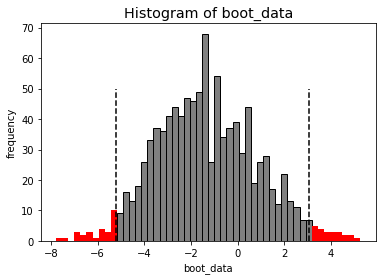

In [41]:
bootstrap_arpu = get_bootstrap(control.revenue, test.revenue)

In [42]:
bootstrap_arpu["p_value"]

0.5327526736665371

Based on p-value 0.53 > 0.05 we cannot reject the null hypothesis. ARPU in the control and test groups do not differ significantly

Let's start checking ARPPU. To do this, we will leave only paying users in our groups

In [43]:
arppu_control = control.query('revenue > 0')
arppu_test = test.query('revenue > 0')

Checking the distributions in these groups

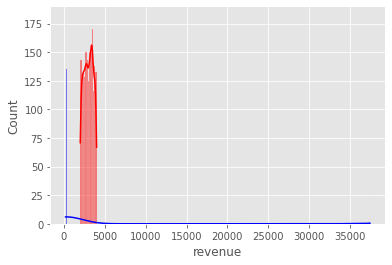

In [44]:
sns.histplot(data=arppu_control, x='revenue', color='blue', label='Control', kde=True)
sns.histplot(data=arppu_test, x='revenue', color='red', label='Test', kde=True)

We also check normality using the Shapiro-Wilk test with the formation of a null hypothesis, according to which the data are distributed normally in the population.

In [45]:
shapiro(arppu_control.revenue)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [46]:
shapiro(arppu_test.revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

The distribution of paying players in the test group has already become normal, and bootstrap is also suitable for testing

Let's form hypotheses for ARPPU:
    
     -H0: ARPPU in the control and test groups do not differ significantly

     -H1: ARPPU in the control and test groups are significantly different

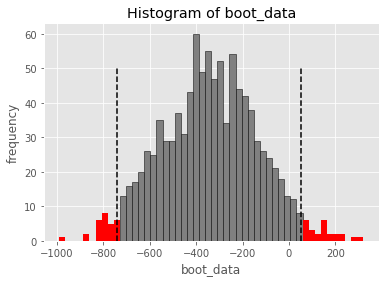

In [47]:
bootstrap_arppu = get_bootstrap(arppu_control.revenue, arppu_test.revenue)

In [48]:
bootstrap_arppu["p_value"]

0.09961023680699671

Based on p-value 0.1 > 0.05 we cannot reject the null hypothesis. ARPPU in the control and test groups do not differ significantly

# Conclusion:

Calculations and checks of such metrics as ARPU (average bill per user), ARPPU (average bill per paying user), CR (conversion into purchase) between the control and test groups were carried out:

Very strong outliers were identified in the control group:

     -purchases of 123 players accounted for more than 80% of the total amount
    
     - the rest of the purchases were disproportionately smaller than in the test group
    
This may indicate an error in the distribution of the control group, or the promotional offers of the control group themselves. It is necessary to discuss these points in more detail with the responsible persons.

     -at the same time, in the test group the average bill was higher and the distribution among paying users was more uniform

- The ARPU metric did not statistically significantly increase in the test group relative to the control group, which means that buyers did not bring more profit to the company
    
- The same can be said about ARPPU in the compared paying groups
    
- There are fewer paying users, but in the test group users are willing to pay more

In my opinion, the set of promotional offers for the test group performed better. It can be called more stable. However, the strange situation in the control group requires more careful consideration with those responsible.

# Task 3

Part 1: Plants & Gardens hosts time-limited themed events every month. In them, players can receive unique items for the garden and characters, additional coins or bonuses. To receive a reward you need to complete a number of levels within a certain time. What metrics can be used to evaluate the results of the last past event?

A small clarification: From the task conditions, we do not know what level of monitization is provided in the application.
They can be of several types:
     - one-time app purchase
     - in-game purchases
     - advertising within the application
     - they can also be combined
However, it would be logical to assume that the application works on in-game purchases and advertising (shareware)
In this case, we can define the following metrics:
     - Retention: it is important for us to have as much online presence as possible in order to reach a larger audience for advertising in the game, and therefore receive more profit from this advertising. Events create greater variety in the game, which fuels players’ interest in it
     - DAU(WAU): ratio of online during the event to normal time. More advertising in a shorter period of time.
     - The number of players who reached the end of the event, and, accordingly, the number of players who abandoned the event and at what stage (funnel). This way we can understand how complex the event is, and whether the next events need to be complicated or simplified.
     - CR - The number of players who purchased any items or other means to simplify the passage of the event, subject to monetization during the events. If we want players to buy them, we need to ensure that as many players as possible make purchases without leaving the event. Of course, there must be a balance between online players, monetization and built-in advertising.
     - The number of new unique players during the event compared to normal time. This way we can also understand how useful events are not only for maintaining the online presence, but also for attracting new users.

Part 2: Suppose in another event we complicated the mechanics of events so that with each unsuccessful attempt to complete a level, the player will roll back several levels. Will the set of outcome assessment metrics change? If so, how?

The metrics in this case will be similar, but the main metrics are the ratio of complex event mechanics to classic ones:
     - The ratio of the number of online players to classic events and to simple days
     - Funnel for understanding at what stage the maximum outflow of players occurs
     - CR subject to monetization during events
     - ARPU. Have players started buying more often and more relative to classic events?
     - Number of players who reached the finish line